### Contact detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass,get_env_obj_names,set_env_obj,set_env_objs,get_env_obj_poses
from pid import PID_ControllerClass
from scipy.spatial.distance import cdist
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


### Spawn objects on the table

In [2]:
env = MuJoCoParserClass(name='Panda',xml_path='../asset/panda/franka_panda_w_objs.xml')
print ("Ready.")

Ready.


Creating window glfw
Creating offscreen glfw


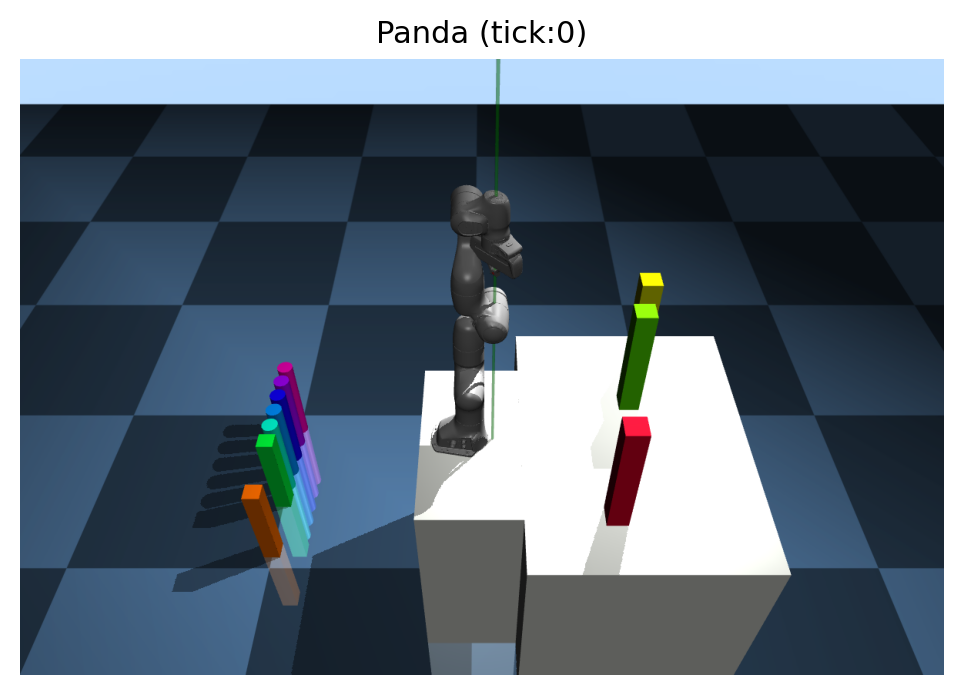

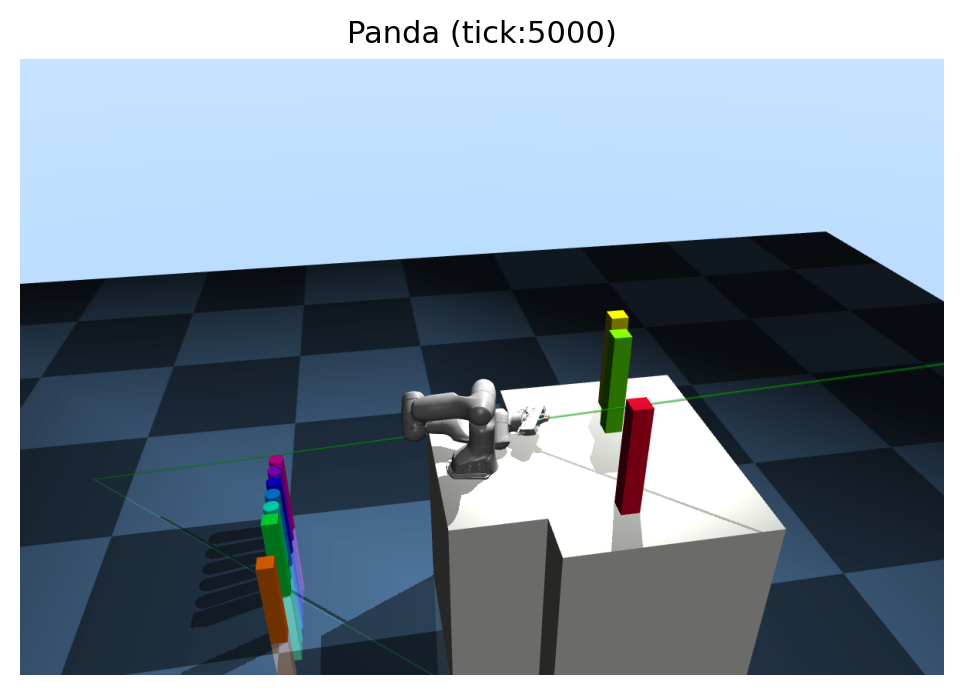

Done.


In [3]:
env.reset()
# Initialize objects 
obj_names = get_env_obj_names(env,prefix='obj_') # available objects
colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(obj_names))]
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [-1.0,0.1*obj_idx,0.0]
    obj_quat  = [0,0,0,1]
    obj_color = colors[obj_idx]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=obj_color)
env.forward(INCREASE_TICK=False) # update object locations
# Randomly place objects on the table
n_place  = 3
x_range  = [0.3,1.0]
y_range  = [-0.5,0.5]
z_range  = [1.01,1.01]
min_dist = 0.15
obj2place_idxs = np.random.permutation(len(obj_names))[:n_place].astype(int)
obj2place_names = [obj_names[o_idx] for o_idx in obj2place_idxs]
obj2place_poses = np.zeros((n_place,3))
for o_idx in range(n_place):
    while True:
        x = np.random.uniform(low=x_range[0],high=x_range[1])
        y = np.random.uniform(low=y_range[0],high=y_range[1])
        z = np.random.uniform(low=z_range[0],high=z_range[1])
        xyz = np.array([x,y,z])
        if o_idx >= 1:
            devc = cdist(xyz.reshape((-1,3)),obj2place_poses[:o_idx,:].reshape((-1,3)),'euclidean')
            if devc.min() > min_dist: break # minimum distance between objects
        else:
            break
    obj2place_poses[o_idx,:] = xyz
set_env_objs(env,obj_names=obj2place_names,obj_poses=obj2place_poses,obj_colors=None)
env.forward(INCREASE_TICK=False) # update object locations
env.plot_scene(figsize=(8,4),title_str='Panda (tick:%d)'%(env.tick),title_fs=11)
# Run simulation
env.init_viewer(window_width=0.5,window_height=0.5,
                cam_azimuth=80.0,cam_distance=3.0,
                cam_elevation=-30.0,cam_lookat=np.array([0,0,1.5]))
max_tick = 5000
while env.tick < max_tick:
    # Update
    env.step()
    # Get object poses (p and R)
    obj_ps,obj_Rs = get_env_obj_poses(env,obj_names)
    for o_idx,obj_name in enumerate(obj_names): # plot objects
        obj_p,obj_R = obj_ps[o_idx,:],obj_Rs[o_idx,:,:]
        # Bottom:red sphere
        env.add_marker(pos=obj_p,radius=0.03,color=[1,0,0,0.5],label='%s'%(obj_name))
    # Get contact information
    contact_infos = env.get_contact_infos()
    for contact_info in contact_infos:
        p_contact = contact_info['p']
        f_contact = contact_info['f']
        f_norm    = contact_info['f_norm']
        bodyname1 = contact_info['bodyname1']
        bodyname2 = contact_info['bodyname2']
        # Plot contact force (action and reaction)
        env.add_arrow(pos=p_contact,uv_arrow=f_contact,r_stem=0.02,len_arrow=f_norm/20,
                      color=[1,0,0.5,0.3],label='')
        env.add_arrow(pos=p_contact,uv_arrow=-f_contact,r_stem=0.02,len_arrow=f_norm/20,
                      color=[0.5,0,1,0.3],label='')
        # Plot 
        env.add_marker(pos=p_contact+0.02*f_contact,radius=0.01,color=[0,0,0,0.5],
                       label='%s-%s'%(bodyname1,bodyname2))
        env.add_marker(pos=p_contact-0.02*f_contact,radius=0.01,color=[0,0,0,0.5],
                       label='%s-%s'%(bodyname1,bodyname2))
    # Render
    env.render()
# Plot the final scene with the same viewer information
viewer_info = env.get_viewer_info() # get the last viewer information
env.plot_scene(figsize=(8,4),title_str='Panda (tick:%d)'%(env.tick),title_fs=11,
               cam_azimuth=viewer_info['cam_azimuth'],cam_distance=viewer_info['cam_distance'],
               cam_elevation=viewer_info['cam_elevation'],cam_lookat=viewer_info['cam_lookat'])
print ("Done.")